In [1]:
import numpy as np
import pandas as pd
import os
import pprint
import sklearn
from sklearn import preprocessing
from sklearn.decomposition import PCA
import warnings
import matplotlib
from os import listdir
import seaborn as sns
import scipy
import sys

import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

import warnings
warnings.filterwarnings("ignore")

import shap
import matplotlib.pyplot as plt

In [2]:
rs = 42

In [3]:
do_shap_scores = 0
do_soft_rankings = 1

In [4]:
os.chdir('..')

In [5]:
prediction_window = "24h"

In [6]:
data_directory = 'AKI Data/eicu_aki/new data/'
prediction_directory = 'observation' + prediction_window + '_prediction24h/'

In [7]:
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

In [8]:
data_files = find_csv_filenames(data_directory+prediction_directory)
hosps = [x.replace('.csv', '') for x in data_files]

#### Loading in Files for First Architecture

In [9]:
model_type = 'Pytorch MLP'

In [10]:
df_top_features = pd.read_csv(f"AKI Code/Feature Importances/{model_type}_" + prediction_window + "_SHAPImportantFeatures.csv")
df_top_features = df_top_features.loc[:, ~df_top_features.columns.str.contains('^Unnamed')]
df_top_features = df_top_features.iloc[0:100]

In [11]:
# Getting list of features and shape for eventual score dataframe
file = str(420) + '.csv'
data = pd.read_csv(data_directory + prediction_directory + "cleaned/" + file)
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
feats_index = list(data)
feats_index.remove('AKI_label')
# 7 hospitals, 1 aggregate
feats_score_shape = (len(feats_index), (7+1))

In [12]:
if do_soft_rankings:
    init_data = np.zeros(feats_score_shape)
    df_soft_rankings = pd.DataFrame(data = init_data, columns=list(df_top_features), index=feats_index)

    s = df_top_features.shape[0] 
    features = np.unique(df_top_features.values)
    for feature in features:
        loc = np.where(df_top_features.values == feature)
        rows = loc[0]
        cols = loc[1]
        feature_index = df_soft_rankings.index.get_loc(feature)
        for i in range(0, len(cols)):
            df_soft_rankings.iloc[feature_index, cols[i]] = np.exp((-1 * (rows[i] + 1))/s)
    df_feat_scores = df_soft_rankings

#### Local Feature Importances for First Architecture

In [13]:
df_top_features_local_first = df_top_features.drop(columns=['Agg'])
df_feat_scores_local_first = df_feat_scores.drop(columns=['Agg'])

features, counts = np.unique(df_top_features_local_first.values, return_counts=True)
props = counts/7
feature_site_props_first = {features[i]: props[i] for i in range(len(features))}

feature_col_dict_first = dict.fromkeys(features)
for feature in feature_col_dict_first:
    loc = np.where(df_top_features_local_first.values == feature)
    cols = loc[1]
    feature_col_dict_first[feature] = cols

feature_score_dict_first = dict.fromkeys(features)
for feature in feature_score_dict_first:
    idx = feature_col_dict_first[feature]
    feature_score_dict_first[feature] = df_feat_scores_local_first.iloc[:, idx].loc[feature].values

feature_median_dict_first = dict.fromkeys(features)
for feature in feature_median_dict_first:
    feature_median_dict_first[feature] = np.median(feature_score_dict_first[feature])
values_first = feature_median_dict_first.values()

#### Aggregate Feature Importances for First Architecture

In [14]:
df_top_features_agg_first = df_top_features['Agg']
df_feat_scores_agg_first = df_feat_scores['Agg']

agg_feature_score_dict_first = dict.fromkeys(df_top_features_agg_first.values)
for feature in agg_feature_score_dict_first:
    agg_feature_score_dict_first[feature] = df_feat_scores_agg_first.loc[feature]

#### Federated Feature Importances for First Architecture

In [15]:
df_top_fed_features = pd.read_csv(f"AKI Code/Feature Importances/Federated {model_type}_" + prediction_window + "_SHAPImportantFeatures.csv")
df_top_fed_features = df_top_fed_features.loc[:, ~df_top_fed_features.columns.str.contains('^Unnamed')]
df_top_fed_features_first = df_top_fed_features.iloc[0:100]

In [16]:
if do_soft_rankings:
    init_data = np.zeros((len(feats_index), 1))
    df_soft_rankings = pd.DataFrame(data = init_data, columns=list(df_top_fed_features_first), index=feats_index)

    s = df_top_fed_features_first.shape[0] 
    features = np.unique(df_top_fed_features_first.values)
    for feature in features:
        loc = np.where(df_top_fed_features_first.values == feature)
        rows = loc[0]
        cols = loc[1]
        feature_index = df_soft_rankings.index.get_loc(feature)
        for i in range(0, len(cols)):
            df_soft_rankings.iloc[feature_index, cols[i]] = np.exp((-1 * (rows[i] + 1))/s)
    df_fed_feat_scores_first = df_soft_rankings

In [17]:
df_all_scores_first = pd.merge(df_feat_scores, df_fed_feat_scores_first, left_index=True, right_index=True)

In [18]:
df_top_features_fed_first = df_top_fed_features_first['fed']
df_feat_scores_fed_first = df_all_scores_first['fed']

In [19]:
fed_feature_score_dict_first = dict.fromkeys(df_top_features_fed_first.values)
for feature in fed_feature_score_dict_first:
    fed_feature_score_dict_first[feature] = df_feat_scores_fed_first.loc[feature]

#### Loading in Files for Second Architecture

In [20]:
model_type = 'XGBoost'

In [21]:
df_top_features = pd.read_csv(f"AKI Code/Feature Importances/{model_type}_" + prediction_window + "_SHAPImportantFeatures.csv")
df_top_features = df_top_features.loc[:, ~df_top_features.columns.str.contains('^Unnamed')]
df_top_features = df_top_features.iloc[0:100]

In [22]:
if do_soft_rankings:
    init_data = np.zeros(feats_score_shape)
    df_soft_rankings = pd.DataFrame(data = init_data, columns=list(df_top_features), index=feats_index)

    s = df_top_features.shape[0] 
    features = np.unique(df_top_features.values)
    for feature in features:
        loc = np.where(df_top_features.values == feature)
        rows = loc[0]
        cols = loc[1]
        feature_index = df_soft_rankings.index.get_loc(feature)
        for i in range(0, len(cols)):
            df_soft_rankings.iloc[feature_index, cols[i]] = np.exp((-1 * (rows[i] + 1))/s)
    df_feat_scores = df_soft_rankings

#### Local Feature Importances for Second Architecture

In [23]:
df_top_features_local_sec = df_top_features.drop(columns=['Agg'])
df_feat_scores_local_sec = df_feat_scores.drop(columns=['Agg'])

features, counts = np.unique(df_top_features_local_sec.values, return_counts=True)
props = counts/7
feature_site_props_sec = {features[i]: props[i] for i in range(len(features))}

feature_col_dict_sec = dict.fromkeys(features)
for feature in feature_col_dict_sec:
    loc = np.where(df_top_features_local_sec.values == feature)
    cols = loc[1]
    feature_col_dict_sec[feature] = cols

feature_score_dict_sec = dict.fromkeys(features)
for feature in feature_score_dict_sec:
    idx = feature_col_dict_sec[feature]
    feature_score_dict_sec[feature] = df_feat_scores_local_sec.iloc[:, idx].loc[feature].values

feature_median_dict_sec = dict.fromkeys(features)
for feature in feature_median_dict_sec:
    feature_median_dict_sec[feature] = np.median(feature_score_dict_sec[feature])
values_sec = feature_median_dict_sec.values()

#### Aggregate Feature Importances for Second Architecture

In [24]:
df_top_features_agg_sec = df_top_features['Agg']
df_feat_scores_agg_sec = df_feat_scores['Agg']

In [25]:
agg_feature_score_dict_sec = dict.fromkeys(df_top_features_agg_sec.values)
for feature in agg_feature_score_dict_sec:
    agg_feature_score_dict_sec[feature] = df_feat_scores_agg_sec.loc[feature]

#### Federated Feature Importances for Second Architecture

In [26]:
df_top_fed_features = pd.read_csv(f"AKI Code/Feature Importances/Federated {model_type}_" + prediction_window + "_SHAPImportantFeatures.csv")
df_top_fed_features = df_top_fed_features.loc[:, ~df_top_fed_features.columns.str.contains('^Unnamed')]
df_top_fed_features_sec = df_top_fed_features.iloc[0:100]

In [27]:
if do_soft_rankings:
    init_data = np.zeros((len(feats_index), 1))
    df_soft_rankings = pd.DataFrame(data = init_data, columns=list(df_top_fed_features_sec), index=feats_index)

    s = df_top_fed_features_sec.shape[0] 
    features = np.unique(df_top_fed_features_sec.values)
    for feature in features:
        loc = np.where(df_top_fed_features_sec.values == feature)
        rows = loc[0]
        cols = loc[1]
        feature_index = df_soft_rankings.index.get_loc(feature)
        for i in range(0, len(cols)):
            df_soft_rankings.iloc[feature_index, cols[i]] = np.exp((-1 * (rows[i] + 1))/s)
    df_fed_feat_scores_sec = df_soft_rankings

In [28]:
df_all_scores_sec = pd.merge(df_feat_scores, df_fed_feat_scores_sec, left_index=True, right_index=True)

In [29]:
df_top_features_fed_sec = df_top_fed_features_sec['fed']
df_feat_scores_fed_sec = df_all_scores_sec['fed']

In [30]:
fed_feature_score_dict_sec = dict.fromkeys(df_top_features_fed_sec.values)
for feature in fed_feature_score_dict_sec:
    fed_feature_score_dict_sec[feature] = df_feat_scores_fed_sec.loc[feature]

In [31]:
df_all_scores_sec

,420,122,243,252,458,199,73,Agg,fed
heartrate_first,0.810584,0.631284,0.755784,0.726149,0.802519,0.860708,0.733447,0.571209,0.000000
sysbp_first,0.537944,0.496585,0.663650,0.878095,0.810584,0.472367,0.904837,0.711770,0.588605
diasbp_first,0.771052,0.690734,0.771052,0.771052,0.644036,0.565525,0.913931,0.637628,0.000000
meanbp_first,0.852144,0.000000,0.548812,0.733447,0.726149,0.913931,0.554327,0.895834,0.852144
resprate_first,0.748264,0.427415,0.826959,0.690734,0.704688,0.631284,0.571209,0.394554,0.000000
...,...,...,...,...,...,...,...,...,...
XANAX,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ZESTRIL,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ZOCOR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ZOLPIDEM,0.000000,0.449329,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Comparison Analysis Between Models

#### At Each Hospital

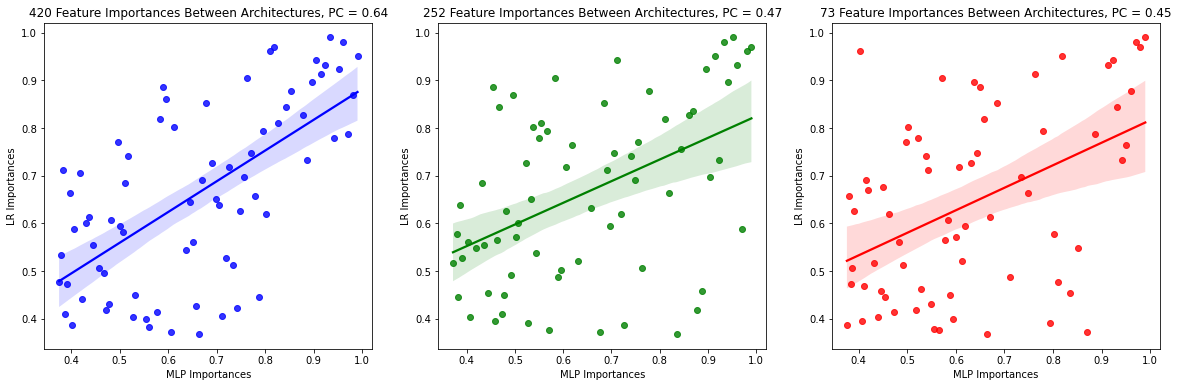

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

In [32]:
num_rows = 1
num_cols = 3

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20,6))
# fig.delaxes(axes[(2, 1)])
# fig.delaxes(axes[(2, 2)])
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

select_hosps = ['420', '252', '73']
for i, hosp in enumerate(select_hosps):
    hosp_local_dict_first = dict(zip(df_all_scores_first.index, df_all_scores_first[hosp]))
    hosp_local_dict_sec = dict(zip(df_all_scores_sec.index, df_all_scores_sec[hosp]))
    hosp_local_dict_first = {x:y for x,y in hosp_local_dict_first.items() if y!=0}
    hosp_local_dict_sec = {x:y for x,y in hosp_local_dict_sec.items() if y!=0}

    df_first = pd.DataFrame(data={'feature':hosp_local_dict_first.keys(), 'First Architecture Importances':hosp_local_dict_first.values()})
    df_sec = pd.DataFrame(data={'feature':hosp_local_dict_sec.keys(), 'Second Architecture Importances':hosp_local_dict_sec.values()})

    plt.figure(figsize=(6,6))        

    df_plot = pd.merge(df_first, df_sec, on='feature')
    first_arch_values = df_plot['First Architecture Importances'].values
    second_arch_values = df_plot['Second Architecture Importances'].values     

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(first_arch_values, second_arch_values)
    my_rho = np.corrcoef(first_arch_values, second_arch_values)

#     ax = axes[divmod(i, num_cols)]
    ax = axes[i]
    g = sns.regplot(data=df_plot, x="First Architecture Importances", y="Second Architecture Importances", ax=ax, color=colors[i])
    g.set_xlabel("MLP Importances")
    g.set_ylabel("LR Importances")
    ax.set_title(hosp + " Feature Importances Between Architectures, PC = {}".format(np.round(my_rho[0, 1], 2)))
    
plt.tight_layout()

#### Across All Hospitals

Text(0.5, 1.0, 'Local Hospital Feature Importances Between Architectures, PC = 0.44')

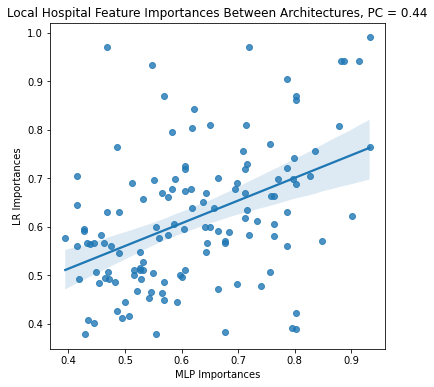

In [33]:
df_first = pd.DataFrame(data={'feature':feature_median_dict_first.keys(), 'First Architecture Importances':feature_median_dict_first.values()})
df_sec = pd.DataFrame(data={'feature':feature_median_dict_sec.keys(), 'Second Architecture Importances':feature_median_dict_sec.values()})

plt.figure(figsize=(6,6))        

df_plot = pd.merge(df_first, df_sec, on='feature')
first_arch_values = df_plot['First Architecture Importances'].values
second_arch_values = df_plot['Second Architecture Importances'].values   

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(first_arch_values, second_arch_values)
my_rho = np.corrcoef(first_arch_values, second_arch_values)

g = sns.regplot(data=df_plot, x="First Architecture Importances", y="Second Architecture Importances")
g.set_xlabel("MLP Importances")
g.set_ylabel("LR Importances")
plt.title("Local Hospital Feature Importances Between Architectures, PC = {}".format(np.round(my_rho[0, 1], 2)))

#### Pooled Data

Text(0.5, 1.0, 'Pooled Data Feature Importances Between Architectures, PC = 0.47')

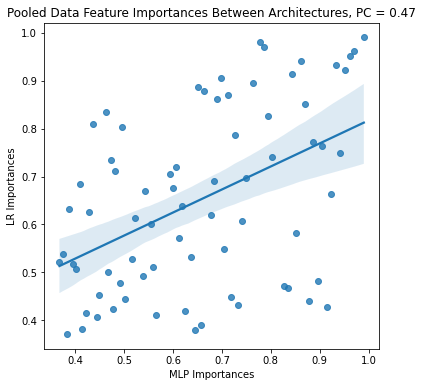

In [34]:
df_first = pd.DataFrame(data={'feature':agg_feature_score_dict_first.keys(), 'First Architecture Importances':agg_feature_score_dict_first.values()})
df_sec = pd.DataFrame(data={'feature':agg_feature_score_dict_sec.keys(), 'Second Architecture Importances':agg_feature_score_dict_sec.values()})

plt.figure(figsize=(6,6))        

df_plot = pd.merge(df_first, df_sec, on='feature')
first_arch_values = df_plot['First Architecture Importances'].values
second_arch_values = df_plot['Second Architecture Importances'].values

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(first_arch_values, second_arch_values)
my_rho = np.corrcoef(first_arch_values, second_arch_values)

g = sns.regplot(data=df_plot, x="First Architecture Importances", y="Second Architecture Importances")
g.set_xlabel("MLP Importances")
g.set_ylabel("LR Importances")
plt.title("Pooled Data Feature Importances Between Architectures, PC = {}".format(np.round(my_rho[0, 1], 2)))

#### Federated Environments

Text(0.5, 1.0, 'Federated Feature Importances Between Architectures, PC = 0.44')

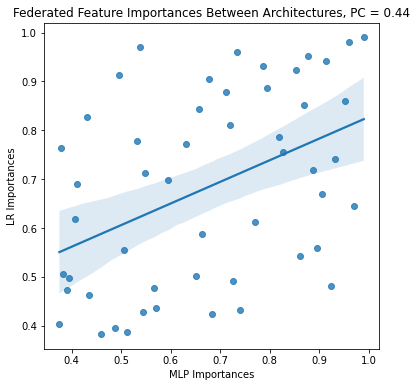

In [35]:
df_first = pd.DataFrame(data={'feature':fed_feature_score_dict_first.keys(), 'First Architecture Importances':fed_feature_score_dict_first.values()})
df_sec = pd.DataFrame(data={'feature':fed_feature_score_dict_sec.keys(), 'Second Architecture Importances':fed_feature_score_dict_sec.values()})

plt.figure(figsize=(6,6))        

df_plot = pd.merge(df_first, df_sec, on='feature')
first_arch_values = df_plot['First Architecture Importances'].values
second_arch_values = df_plot['Second Architecture Importances'].values

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(first_arch_values, second_arch_values)
my_rho = np.corrcoef(first_arch_values, second_arch_values)

g = sns.regplot(data=df_plot, x="First Architecture Importances", y="Second Architecture Importances")
g.set_xlabel("MLP Importances")
g.set_ylabel("LR Importances")
plt.title("Federated Feature Importances Between Architectures, PC = {}".format(np.round(my_rho[0, 1], 2)))